In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings

rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)
warnings.simplefilter('ignore')

In [ ]:
# data load

# Load the data

data_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\data\astronomical-object')
feature_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\feature')
sub_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\sub')
val_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\val')
tst_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'type'
seed = 42

target_col = 'type'
n_fold = 5
n_class = 19
seed = 42

In [3]:
algo_name = 'lrcv' #logistic regression cv
#KFold로 CV 하는 경우는 2가지, 성능 평가 or stacking
#KFold로 학습한 모델 5개를 그대로 보관하고, 각각 예측 후, 평균 or voting 
#soft voting, hard voting -> 이 경우는 앙상블임.
#이런 걸 여러 개 만들어서 쌓으면 stacking

feature_name = 'polyfeature'
model_name = f'{algo_name}_{feature_name}' #lrcv_Polyfeature

feature_file = feature_dir / f'{feature_name}.csv' # 나중에 to_csv 위치
p_val_file = val_dir / f'{model_name}.val.csv' # cv 예측값 나중에 앙상블 때 사용
p_tst_file = tst_dir / f'{model_name}.tst.csv' # 이건 뭐지
sub_file = sub_dir / f'{model_name}.csv' # 테스트셋으로 예측 후, 서브미션 파일에 저장

## Polynomial Feature 생성

In [4]:
df = pd.read_csv(feature_dir / 'feature.csv', index_col = 0)
print(df.shape)
df.head() # feature engineer한 후, train set, data set 합쳐놓은 것

(210000, 21)


,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
0,QSO,6.4003,23.1982,21.4320,21.3141,21.1766,21.1714,21.6445,21.6576,21.3877,21.5728,22.5043,21.4316,21.4783,21.1454,20.4224,22.7492,21.4655,21.3642,21.0206,21.1473
1,QSO,6.6708,21.4314,20.7081,20.6789,20.7034,20.4732,21.0298,20.9671,20.9377,21.0636,21.3607,20.7790,20.8897,20.6398,20.6467,21.4930,20.7585,20.7539,20.6934,20.5123
2,QSO,6.0591,17.8515,16.7279,16.6797,16.6946,16.6418,17.0331,16.9997,17.0960,17.0764,17.8673,16.7388,16.6889,16.7442,16.8080,17.8181,16.6974,16.6412,16.6602,16.6889
3,QSO,6.7627,20.7899,20.0404,19.9269,19.8438,19.4633,20.3172,20.2179,20.0739,19.7945,20.4339,19.9937,19.9855,19.7509,19.4551,20.7707,20.0017,19.8898,19.7581,19.5529
4,STAR_RED_DWARF,6.4184,26.4550,23.0588,21.4714,19.5050,18.3891,23.6291,21.7428,19.8617,18.8104,25.8592,22.4269,21.6736,19.6100,18.3761,24.8771,23.1480,21.4753,19.4873,18.3757


In [5]:
scaler = StandardScaler()
poly = PolynomialFeatures(2) # PolynomialFeatures 객체 안에 인자 입력 후, 생성

X = poly.fit_transform(scaler.fit_transform(df.drop(target_col, axis = 1)))
# X에는 무엇이 들어가는가?
# target_col을 제외한 독립변수는 (n_samples, n_polynomial_features)의 ndarray가 반환됨

# scaler.fit_transform하면 df가 numpy.ndarray으로 바뀜. poly.fit_trasnform() 적용하면 ndarray
# 따라서 X.columns를 통해 피쳐들의 이름 값을 얻어낸는 건 불가능.
# get_feature_names_out으로 df.columns들의 조합들로 피쳐변환 한 조합들의 이름들을 반환해줌
feature_names = poly.get_feature_names_out(df.drop('type', axis = 1).columns)

In [30]:
feature_names

array(['1', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r',
       'modelMag_i', 'modelMag_z', 'fiberID^2', 'fiberID psfMag_u',
       'fiberID psfMag_g', 'fiberID psfMag_r', 'fiberID psfMag_i',
       'fiberID psfMag_z', 'fiberID fiberMag_g', 'fiberID fiberMag_r',
       'fiberID fiberMag_i', 'fiberID fiberMag_z', 'fiberID petroMag_u',
       'fiberID petroMag_g', 'fiberID petroMag_r', 'fiberID petroMag_i',
       'fiberID petroMag_z', 'fiberID modelMag_u', 'fiberID modelMag_g',
       'fiberID modelMag_r', 'fiberID modelMag_i', 'fiberID modelMag_z',
       'psfMag_u^2', 'psfMag_u psfMag_g', 'psfMag_u psfMag_r',
       'psfMag_u psfMag_i', 'psfMag_u psfMag_z', 'psfMag_u fiberMag_g',
       'psfMag_u fiberMag_r', 'psfMag_u fiberMag_i',
       'psfMag_u fiberMag_z', 'psfMag_u pe

In [31]:
print(feature_names.size)

231


In [32]:
print(X.shape)

(210000, 231)


In [33]:
df_poly = pd.DataFrame(data = X, columns = feature_names, index = df.index)
# df의 인덱스를 index로 사용. 즉, id = 0,1,2,3..
# 즉, 우리는 df_poly를 통해, polynimial 된 data frame을 만들게 됨

df_poly[target_col] = df[target_col] # target_col 만들어서 복구해주기

df_poly.head()
df_poly.to_csv(feature_file) # polynomial 된 feature file. 파일 확인할 것

In [34]:
y = df[target_col].values[:199991] # ndarray로 바꿔주기
df.drop(target_col, inplace = True, axis = 1)
trn = df.iloc[:199991].values # ndarray로 바꿔주기
tst = df.iloc[199991:].values
feature_name = df.columns.tolist()
#참고로 df.columns 는 리스트 아님. 리스트처럼 보이지만.
# df.columns.tolist() 가 진짜 리스트

print(y.shape, trn.shape, tst.shape)

(199991,) (199991, 20) (10009, 20)


# Startified K-Fold Cross Validation

In [35]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

# cv 객체 만들어주기. cv를 StartifiedKFold 스타일로 하겠다는 것.

In [36]:
p_val = np.zeros((trn.shape[0], n_class)) #cv셋 예측값 저장용
p_tst = np.zeros((tst.shape[0], n_class)) #tst셋 예측값 저장용

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
  # trn, y를 cv객체로 나누면 -> startified Kfold로 총 5번
  # i_trn, i_val이 등장함.
  print(f'training model for CV #{i}')
  clf = LogisticRegression(multi_class = 'multinomial')
  clf.fit(trn[i_trn], y[i_trn])
  # 매 학습마다 클래시피케이션 객체를 새로 만들어서, 학습.
  # 독립 학습임.
  p_val[i_val, :] = clf.predict_proba(trn[i_val])
  # i_val은 검증 샘플 인덱스들임 [0,4,7,9 ...] 이런 식으로.
  # 개별적으로 로우들을 뽑아냄
  # 이게 Out of Fold(OOF) 예측값 저장용임. 
  p_tst += clf.predict_proba(tst) / n_fold
  # 다른 데이터셋으로 학습한 모델을 동일한 테스트셋으로 평가한 후,
  # 평균을 내어, 모델의 예측결과를 평균 soft voting 하는 방식임 (앙상블)
  # K-Fold Soft Voting 앙상블

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [37]:
print(f'{accuracy_score(y, np.argmax(p_val, axis = 1))*100:.4f}%')

0.0000%


p_val은 정수형 클래스 인덱스를 예측하고 있고, y는 문자열(class label)이다.
즉, np.argmax(p_val, axis=1)과 y의 값 타입이 서로 다르기 때문에 전혀 일치하지 않습니다.

Q. 이 문장이 잘 이해가 안 가. p_val은 전체 학습셋에 대한, 각 원소에 확률값이 들어있는거잖아. y는 문자열이고. 아~ 정수랑, 문자열이라 조합이안된다는건가. np.argmax(p_val, axis = 1)은 그러면, p_val 기준, 로우 방향으로 가장 높은 값을 반환하는거고. 그 값들이랑 문자열이랑 비교하려니까 안되는거고. 그래서 y를 정수형으로 라벨링 0,1,2...18로 해서, 다시 비교하려는거고.

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y) # 'Galaxy' -> 0, 'QSQ' -> 1...

print(f'{accuracy_score(y_encoded, np.argmax(p_val, axis=1))*100:.4f}%') 

48.3537%


확실히 로지스틱 리그레션은 선형이라 그런지, 예측이 매우 안 좋음

In [39]:
print(p_val.shape, p_tst.shape)

#p_val 전체 trn셋으로 학습하고 cv한 것.
#p_tst 테스트셋 예측값

(199991, 19) (10009, 19)


In [40]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<Axes: ylabel='feature'>

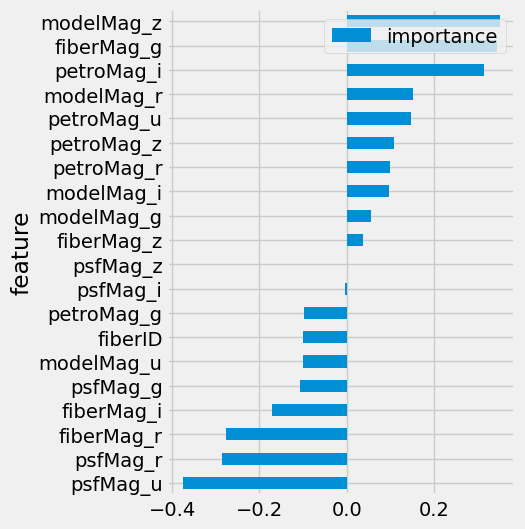

In [41]:
# feature importance visualization
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.coef_[1, :].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(4, 6))

In [42]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(10009, 19)


,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
sub_col = sub.columns.tolist()
sub[sub_col] = p_tst
print(sub_col)
# clf.classes_ 기준 열 순서 -> sub.columns 기준 열 순서로 인덱스 찾기

idx = [list(clf.classes_).index(col) for col in sub_col]

p_tst_ordered = p_tst[:, idx]

sub[sub.columns] = p_tst_ordered

['STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF', 'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY', 'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D', 'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD', 'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']


In [44]:
sub.head()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0009,0.0671,0.0011,0.0263,0.0084,0.0040,0.0159,0.0003,0.0011,0.0002,8.4251e-01,0.0021,7.4335e-07,0.0200,0.0071,0.0019,0.0011,1.9050e-05,0.0001
199992,0.0252,0.0371,0.0109,0.0346,0.1195,0.0715,0.0328,0.0261,0.2598,0.0036,5.7423e-03,0.0529,1.2352e-05,0.1074,0.0353,0.1141,0.0097,2.8008e-04,0.0535
199993,0.0154,0.0553,0.0106,0.0300,0.0608,0.0475,0.4193,0.0150,0.0641,0.0033,1.3721e-02,0.0482,3.1448e-05,0.0963,0.0434,0.0591,0.0105,3.5027e-04,0.0071
199994,0.0065,0.0012,0.0013,0.0030,0.0603,0.0891,0.0020,0.0252,0.4228,0.0004,2.8066e-05,0.0202,2.1947e-06,0.0098,0.0031,0.0653,0.0009,2.9119e-05,0.2889
199995,0.0045,0.1273,0.0050,0.0675,0.0304,0.0116,0.0342,0.0022,0.0131,0.0010,5.7036e-01,0.0113,4.1609e-06,0.0810,0.0258,0.0088,0.0050,9.4763e-05,0.0008


In [45]:
sub.to_csv(sub_file)